In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using Spectrogram instead of the Chromagram so implemented a SpectrogramDataset Class to convert the spectrograms into 3D tensors to pass as input to our model.

In [ ]:
#create dataloaders for training
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

class SpectrogramDataset(Dataset):
    def __init__(self, pkl_file):
        self.data = pd.read_pickle(pkl_file)
        self.labels = sorted(self.data['label'].unique())
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        specto = self.data.iloc[idx]['spectrogram']
        label = self.data.iloc[idx]['label']

        # Normalize spectrogram to [0, 1] using min-max scaling
        specto_norm = (specto - specto.min()) / (specto.max() - specto.min() + 1e-6)
        # Convert to uint8 image, values: 0-255
        img_array = (specto_norm * 255).astype(np.uint8)

        # 2D array -> image
        img = Image.fromarray(img_array)
        img = img.convert("RGB")  # 3 channels
        tensor = transforms.ToTensor()(img)  # img -> tensor

        label_idx = self.label_to_idx[label]

        return tensor, label_idx

# Create datasets and Dataloaders
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/APS360-project/Chord_Pandas_Dataset_specto/"
train_pkl = os.path.join(DATASET_PATH, "train.pkl")
val_pkl   = os.path.join(DATASET_PATH, "val.pkl")
test_pkl  = os.path.join(DATASET_PATH, "test.pkl")

train_dataset_resnet = SpectrogramDataset(train_pkl)
val_dataset_resnet = SpectrogramDataset(val_pkl)
test_dataset_resnet = SpectrogramDataset(test_pkl)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True, num_workers=2)
val_loader_resnet   = DataLoader(val_dataset_resnet, batch_size=32, shuffle=False, num_workers=2)
test_loader_resnet  = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
from torchvision.models import ResNet18_Weights

classes_num = len(train_dataset_resnet.labels)

#load pretrained ResNet model
resnet_model = models.resnet18(pretrained=True)

#freeze fall layers first and then unfreeze layer 4 and fc
for name, param in resnet_model.named_parameters():
    #freeze all
    param.requires_grad = False
    if "layer1" in name or "layer2" in name or "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

#replace the last FC layer to output the chord classes
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.6),
    nn.Linear(in_features, classes_num)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

In [ ]:
import time

def train_model_resnet(model, train_loader, val_loader, num_epochs, criterion, optimizer):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  start_time = time.time()
  train_acc_history = np.zeros(num_epochs)
  val_acc_history = np.zeros(num_epochs)
  train_loss_history = np.zeros(num_epochs)
  val_loss_history = np.zeros(num_epochs)

  print("Starting Training")
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(features)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss_history[epoch] = train_loss/ len(train_loader)
    train_acc_history[epoch] = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
      for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss_history[epoch] = val_loss / len(val_loader)
    val_acc_history[epoch] = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_history[epoch]:.4f}, Train Acc: {train_acc_history[epoch]:.4f}, || Val Loss: {val_loss_history[epoch]:.4f}, Val Acc: {val_acc_history[epoch]:.4f}")

  print("Finished Training")
  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  #save training files
  path = "/content/drive/My Drive/Colab Notebooks/APS360-project/resnet"
  np.savetxt("{}train_acc.csv".format(path), train_acc_history)
  np.savetxt("{}val_acc.csv".format(path), val_acc_history)
  np.savetxt("{}train_loss.csv".format(path), train_loss_history)
  np.savetxt("{}val_loss.csv".format(path), val_loss_history)

In [ ]:
import matplotlib.pyplot as plt

def plot_curves():
  path = "/content/drive/My Drive/Colab Notebooks/APS360-project/resnet"

  train_acc = np.loadtxt("{}train_acc.csv".format(path))
  val_acc = np.loadtxt("{}val_acc.csv".format(path))
  train_loss = np.loadtxt("{}train_loss.csv".format(path))
  val_loss = np.loadtxt("{}val_loss.csv".format(path))

  plt.title("Train vs Val Accuracy: Transfer Learning RESNET model")
  n = len(train_acc)
  plt.plot(range(1, n+1), train_acc, label = "Train Accuracy")
  plt.plot(range(1, n+1), val_acc, label = "Val Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.title("Train vs Val Loss: Transfer Learning RESNET model")
  plt.plot(range(1, n+1), train_loss, label = "Train Loss")
  plt.plot(range(1, n+1), val_loss, label = "Val Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

Starting Training
Epoch 1/40, Train Loss: 4.0894, Train Acc: 0.4293, || Val Loss: 3.1135, Val Acc: 0.5278
Epoch 2/40, Train Loss: 1.2174, Train Acc: 0.5492, || Val Loss: 0.6642, Val Acc: 0.6520
Epoch 3/40, Train Loss: 1.3083, Train Acc: 0.5417, || Val Loss: 0.7059, Val Acc: 0.6111
Epoch 4/40, Train Loss: 0.8344, Train Acc: 0.5805, || Val Loss: 0.6212, Val Acc: 0.6503
Epoch 5/40, Train Loss: 0.6880, Train Acc: 0.6223, || Val Loss: 0.6006, Val Acc: 0.6324
Epoch 6/40, Train Loss: 0.8477, Train Acc: 0.6158, || Val Loss: 2.7889, Val Acc: 0.3627
Epoch 7/40, Train Loss: 1.5211, Train Acc: 0.5327, || Val Loss: 1.0734, Val Acc: 0.4984
Epoch 8/40, Train Loss: 1.2943, Train Acc: 0.5690, || Val Loss: 0.8434, Val Acc: 0.6209
Epoch 9/40, Train Loss: 0.7487, Train Acc: 0.6123, || Val Loss: 0.5958, Val Acc: 0.6863
Epoch 10/40, Train Loss: 0.9458, Train Acc: 0.5909, || Val Loss: 0.6650, Val Acc: 0.6454
Epoch 11/40, Train Loss: 0.7937, Train Acc: 0.6295, || Val Loss: 0.5627, Val Acc: 0.7075
Epoch 12/40,

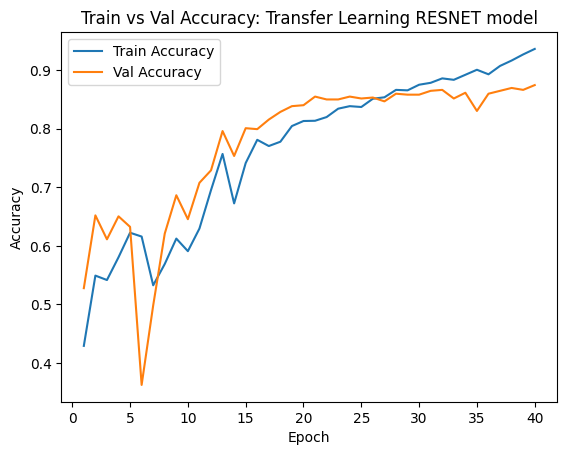

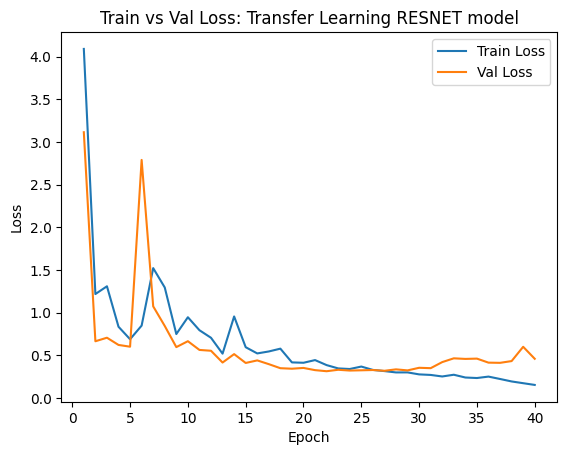

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {"params": resnet_model.layer1.parameters(), "lr": 0.001},
    {"params": resnet_model.layer2.parameters(), "lr": 0.001},
    {"params": resnet_model.layer3.parameters(), "lr": 0.01},
    {"params": resnet_model.layer4.parameters(), "lr": 0.01}, #lower learning rate for tuning layer 4
    {"params": resnet_model.fc.parameters(), "lr": 0.02} #higher learning rate for final layer
], momentum=0.9, weight_decay = 5e-4)

num_epochs = 40

train_model_resnet(resnet_model, train_loader_resnet, val_loader_resnet, num_epochs, criterion, optimizer)
plot_curves()

## Seems to be an overfitting past 30 epochs so we will reduce the num_epochs to 30.

Starting Training
Epoch 1/30, Train Loss: 2.6246, Train Acc: 0.4426, || Val Loss: 1.2506, Val Acc: 0.5474
Epoch 2/30, Train Loss: 1.1287, Train Acc: 0.5533, || Val Loss: 0.6348, Val Acc: 0.6797
Epoch 3/30, Train Loss: 0.7329, Train Acc: 0.6160, || Val Loss: 0.5901, Val Acc: 0.7010
Epoch 4/30, Train Loss: 2.7538, Train Acc: 0.5466, || Val Loss: 1.4038, Val Acc: 0.5163
Epoch 5/30, Train Loss: 1.5392, Train Acc: 0.5184, || Val Loss: 0.8980, Val Acc: 0.5784
Epoch 6/30, Train Loss: 1.6212, Train Acc: 0.5102, || Val Loss: 0.7215, Val Acc: 0.6340
Epoch 7/30, Train Loss: 1.9545, Train Acc: 0.4975, || Val Loss: 1.4302, Val Acc: 0.4216
Epoch 8/30, Train Loss: 0.9058, Train Acc: 0.5699, || Val Loss: 1.4093, Val Acc: 0.5310
Epoch 9/30, Train Loss: 0.9613, Train Acc: 0.5968, || Val Loss: 0.6797, Val Acc: 0.6340
Epoch 10/30, Train Loss: 0.7109, Train Acc: 0.6134, || Val Loss: 0.6209, Val Acc: 0.6585
Epoch 11/30, Train Loss: 1.3167, Train Acc: 0.5513, || Val Loss: 0.7946, Val Acc: 0.6144
Epoch 12/30,

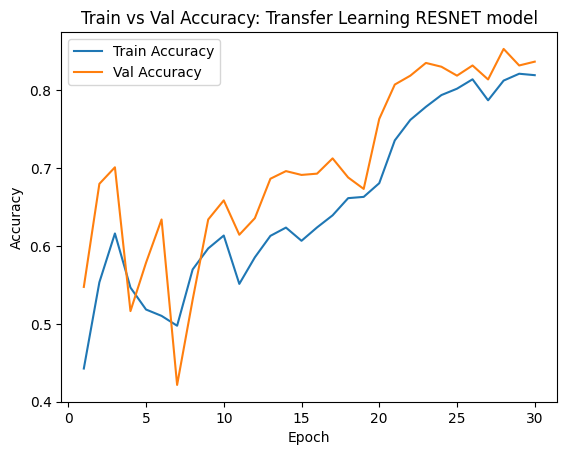

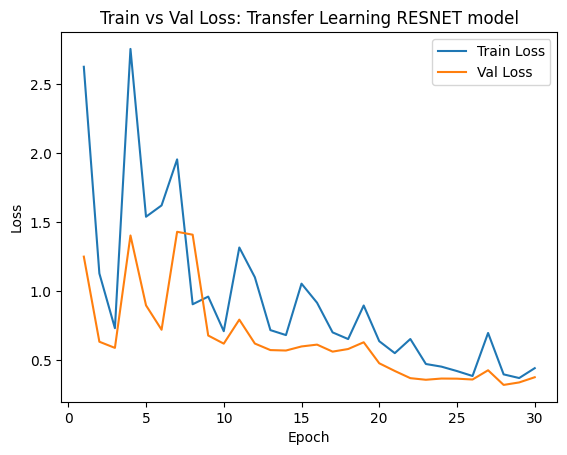

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {"params": resnet_model.layer1.parameters(), "lr": 0.001},
    {"params": resnet_model.layer2.parameters(), "lr": 0.001},
    {"params": resnet_model.layer3.parameters(), "lr": 0.01},
    {"params": resnet_model.layer4.parameters(), "lr": 0.01}, #lower learning rate for tuning layer 4
    {"params": resnet_model.fc.parameters(), "lr": 0.02} #higher learning rate for final layer
], momentum=0.9, weight_decay = 5e-4)

num_epochs = 30
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_model_resnet(resnet_model, train_loader_resnet, val_loader_resnet, num_epochs, criterion, optimizer)
plot_curves()

In [ ]:
#test model function
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = test_correct / len(test_loader.dataset)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [ ]:
# Confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    all_preds = []
    all_labels = []

    misclassified_examples = []

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)  # Get predicted labels

            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified_examples.append((features[i], labels[i], preds[i]))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    chord_labels = dataset.labels

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=chord_labels, yticklabels=chord_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return misclassified_examples

# Testing Unseen Test Data (remaining 10% of split)

Test Loss: 0.6416, Test Accuracy: 0.8350


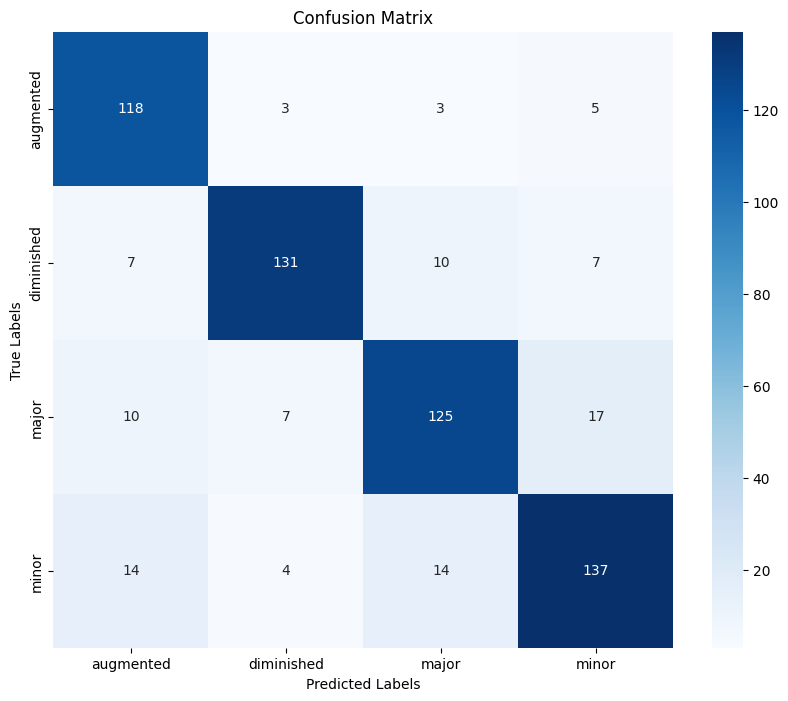

101 misclassified examples out of  612


In [ ]:
test_model(resnet_model, test_loader_resnet, criterion)
misclassified_examples = plot_confusion_matrix(resnet_model, test_loader_resnet, test_dataset_resnet)
print(len(misclassified_examples), "misclassified examples out of ", len(test_dataset_resnet))

# Testing Noisy Unseen Data

Test Loss: 0.4653, Test Accuracy: 0.8186


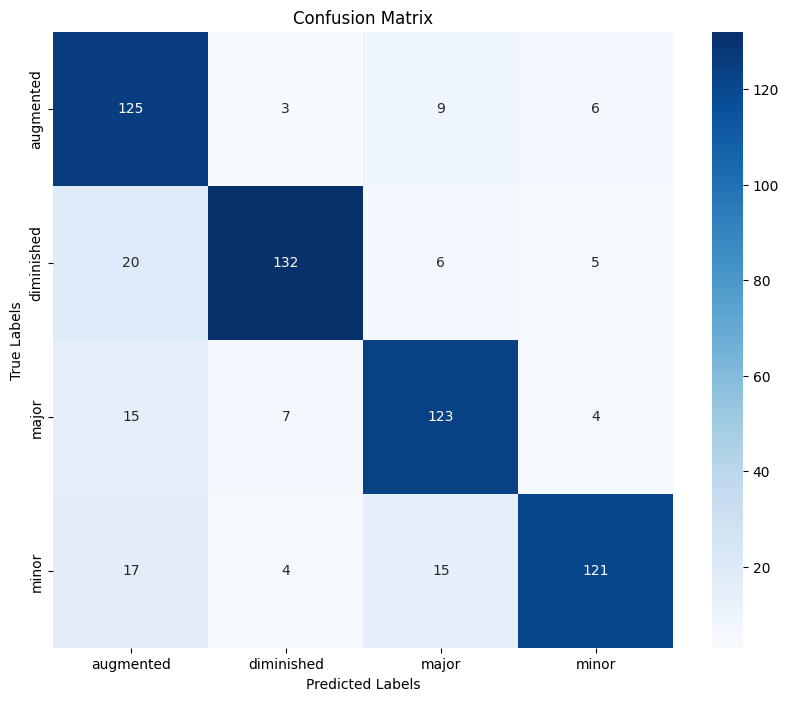

111 misclassified examples out of  612


In [ ]:
test_dataset_resnet_new = SpectrogramDataset('/content/drive/My Drive/Colab Notebooks/APS360-project/Chord_Pandas_Dataset_specto_unseen_1/test.pkl')

test_loader_resnet_new  = DataLoader(test_dataset_resnet_new, batch_size=32, shuffle=False, num_workers=2)

test_model(resnet_model, test_loader_resnet_new, criterion)
misclassified_examples = plot_confusion_matrix(resnet_model, test_loader_resnet_new, test_dataset_resnet_new)
print(len(misclassified_examples), "misclassified examples out of ", len(test_dataset_resnet_new))

Decrease in test accuracy which is expected since the chords have more noise.